In [ ]:
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neural_network import MLPClassifier
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from threading import Thread
from google.colab import drive


class PCA_OWN:
    def __init__(self, n_components):
        self.n_components = n_components
        self.components = None
        self.mean = None

    def fit(self, X):
        # Calculate the mean of the input data
        self.mean = np.mean(X, axis=0)

        # Center the data by subtracting the mean
        centered_X = X - self.mean

        # Calculate the covariance matrix
        covariance = np.cov(centered_X, rowvar=False)

        # Calculate the eigenvalues and eigenvectors of the covariance matrix
        eigenvalues, eigenvectors = np.linalg.eig(covariance)

        # Sort the eigenvalues and eigenvectors in descending order
        indices = np.argsort(eigenvalues)[::-1]
        sorted_eigenvalues = eigenvalues[indices]
        sorted_eigenvectors = eigenvectors[:, indices]

        # Select the top n_components eigenvectors
        self.components = sorted_eigenvectors[:, :self.n_components]

    def transform(self, X):
        # Center the data by subtracting the mean
        centered_X = X - self.mean

        # Project the centered data onto the eigenvectors
        transformed_X = np.dot(centered_X, self.components)

        return transformed_X


def svm_func(X_Train, X_Test, is_own: bool):
    # Define the parameter grid with different kernel options
    param_grid = {'kernel': ['linear', 'poly', 'rbf']}

    # Create an SVM classifier
    svm = SVC()

    # SVM Classifier with Cross-Validation with 5 folds
    grid_search = GridSearchCV(svm, param_grid, cv=5, scoring='accuracy', )

    # Fit the GridSearchCV object to the training data
    t1 = datetime.datetime.now()
    grid_search.fit(X_Train, y_train)
    t2 = datetime.datetime.now()

    # Get the best kernel and its associated accuracy
    best_kernel = grid_search.best_params_['kernel']
    best_accuracy = grid_search.best_score_
    best_estimator = grid_search.best_estimator_

    #  Get the Metrics
    y_predict = best_estimator.predict(X_Test)
    best_accuracy_test = accuracy_score(y_test, y_predict)
    best_precision_test = precision_score(y_test, y_predict, average='weighted')
    best_recall_test = recall_score(y_test, y_predict, average='weighted')
    best_f1_test = f1_score(y_test, y_predict, average='weighted')
    best_confusion_matrix_test = confusion_matrix(y_test, y_predict)

    # Get the accuracy, precision, recall, and F1 score of all kernel types
    all_kernels = grid_search.cv_results_['param_kernel']
    all_accuracies = []
    for i in range(5):  # CV Number of Folds
        all_accuracies.append(grid_search.cv_results_[f'split{i}_test_score'][0])
    all_precision = []
    for i in range(5):  # CV Number of Folds
        all_precision.append(grid_search.cv_results_[f'split{i}_test_score'][1])
    all_recall = []
    for i in range(5):  # CV Number of Folds
        all_recall.append(grid_search.cv_results_[f'split{i}_test_score'][2])
    all_f1 = []
    for i in range(5):  # CV Number of Folds
        all_f1.append((all_precision[i] * all_recall[i]) / (all_precision[i] + all_recall[i]))  # Because F1
        # Score is not Provided directly in the return result from grid search
    tuning_time = t2 - t1

    #  Result
    result = f"Train Results : \nBest Kernel : {best_kernel}\nBest Accuracy : {best_accuracy}\n Best Precision : {max(*all_precision)}" \
             f"\nBest Recall : {max(*all_recall)}\nBest F1 Score : {max(*all_f1)}\nTuning Time : {tuning_time}\n" \
             f"********************************************************************************"

    for kernel, accuracy, precision, recall, f1 in zip(all_kernels, all_accuracies, all_precision, all_recall, all_f1):
        result += f"\nKernel : {kernel}, Accuracy : {accuracy}, Precision : {precision}, Recall : {recall}, " \
                  f"F1 Score : {f1}"

    result += f"\nTest Results : \nBest Accuracy : {best_accuracy_test}\nBest Precision : {best_precision_test}" \
              f"\nBest Recall : {best_recall_test}\nBest F1 Score : {best_f1_test}" \
              f"\nBest Confusion Matrix : {best_confusion_matrix_test}"

    #  Log
    st1 = 'built-in'
    st2 = 'own'
    if is_own:
        with open(f"/content/drive/MyDrive/results_svm_{st1}.txt", "w") as f:
            f.writelines(result)
    if not is_own:
        with open(f"/content/drive/MyDrive/results_svm_{st2}.txt", "w") as f:
            f.writelines(result)
    print(result)


def bayes_func(X_Train, X_Test, is_own: bool):
    # Create an Instance of Bayes Classifier
    naive_bayes = GaussianNB()

    # Train the Model
    t1 = datetime.datetime.now()
    naive_bayes.fit(X_Train, y_train)
    t2 = datetime.datetime.now()

    # Test the Model
    y_predict = naive_bayes.predict(X_Test)

    # Prepare the Results
    accuracy = accuracy_score(y_test, y_predict)
    precision = precision_score(y_test, y_predict, average='weighted')
    recall = recall_score(y_test, y_predict, average='weighted')
    f1 = f1_score(y_test, y_predict, average='weighted')
    confusion_mat = confusion_matrix(y_test, y_predict)
    training_time = t2 - t1

    #  Result
    result = f"Accuracy : {accuracy}\nPrecision : {precision}\nRecall : {recall}\nF1 Score : {f1}" \
             f"\nConfusion Matrix : {confusion_mat}\nTraining Time : {training_time}"

    #  Log
    st1 = 'built-in'
    st2 = 'own'
    if is_own:
        with open(f"/content/drive/MyDrive/results_bayes_{st1}.txt", "w") as f:
            f.writelines(result)
    if not is_own:
        with open(f"/content/drive/MyDrive/results_bayes_{st2}.txt", "w") as f:
            f.writelines(result)
    print(result)


def knn_func(X_Train, X_Test, is_own: bool):
    # Define hyperparameters to search over
    param_dist = {
        'n_neighbors': np.arange(1, 101),  # Range of neighbors to try
    }

    # Perform randomized search for best number of neighbors using 5-fold cross-validation
    t1 = datetime.datetime.now()
    random_search = RandomizedSearchCV(KNeighborsClassifier(), param_dist, n_iter=10, cv=5)
    random_search.fit(X_Train, y_train)
    t2 = datetime.datetime.now()

    # Get best number of neighbors
    best_neighbors = random_search.best_params_['n_neighbors']

    # Use the best number of neighbors to create the KNN classifier
    knn_best = random_search.best_estimator_

    # Predict labels for test data
    y_predict = knn_best.predict(X_Test)

    # Calculate accuracy, precision, recall, and F1 score, confusion matrix and tuning time
    accuracy = accuracy_score(y_test, y_predict)
    precision = precision_score(y_test, y_predict, average='weighted')
    recall = recall_score(y_test, y_predict, average='weighted')
    f1 = f1_score(y_test, y_predict, average='weighted')
    confusion_mat = confusion_matrix(y_test, y_predict)
    tuning_time = t2 - t1

    #  Result
    result = f"Accuracy : {accuracy}\nPrecision : {precision}\nRecall : {recall}\nF1 Score : {f1}" \
             f"\nConfusion Matrix : {confusion_mat}\nBest number of neighbors : {best_neighbors}" \
             f"\nTuning Time : {tuning_time}"

    #  Log
    st1 = 'built-in'
    st2 = 'own'
    if is_own:
        with open(f"/content/drive/MyDrive/results_knn_{st1}.txt", "w") as f:
            f.writelines(result)
    if not is_own:
        with open(f"/content/drive/MyDrive/results_knn_{st2}.txt", "w") as f:
            f.writelines(result)
    print(result)


def mlp_func(X_Train, X_Test, is_own: bool):
    # Define a range of choices for each Hyper-Parameter
    param_grid = {
        'hidden_layer_sizes': [(100, 100), (50, 100)],
        'activation': ['relu', 'tanh', 'logistic',],
        'learning_rate_init': [0.001, 0.01],
        'batch_size': [64],
        'max_iter': [30],
    }

    # Create an MLP classifier
    mlp = MLPClassifier(random_state=42)

    # Five Fold Cross Validation with MLP Classifier
    grid_search = GridSearchCV(mlp, param_grid, cv=5)

    # Fit on the Data
    t1 = datetime.datetime.now()
    grid_search.fit(X_Train, y_train)
    t2 = datetime.datetime.now()

    # Get the best hyperparameters
    best_params = grid_search.best_params_

    #  Get the Best Estimator
    mlp_best = grid_search.best_estimator_

    # Predict labels for test data
    y_predict = mlp_best.predict(X_Test)

    # Calculate accuracy, precision, recall, and F1 score, confusion matrix and tuning time
    accuracy = accuracy_score(y_test, y_predict)
    precision = precision_score(y_test, y_predict, average='weighted')
    recall = recall_score(y_test, y_predict, average='weighted')
    f1 = f1_score(y_test, y_predict, average='weighted')
    confusion_mat = confusion_matrix(y_test, y_predict)
    tuning_time = t2 - t1

    # Result
    result = f"Best Parameters : {best_params}\nBest Accuracy : {accuracy}\nBest Precision : {precision}" \
             f"\nBest Recall : {recall}\nBest F1 Score : {f1}\nBest Confusion Matrix : {confusion_mat}" \
             f"Tuning Time : {tuning_time}"

    #  Log
    st1 = 'built-in'
    st2 = 'own'
    if is_own:
        with open(f"/content/drive/MyDrive/results_mlp_{st1}.txt", "w") as f:
            f.writelines(result)
    if not is_own:
        with open(f"/content/drive/MyDrive/results_mlp_{st2}.txt", "w") as f:
            f.writelines(result)
    print(result)


if __name__ == '__main__':
    # Load the Fashion-MNIST dataset
    drive.mount('/content/drive')
    data_train = pd.read_csv('/content/drive/MyDrive/fashion-mnist_train.csv')
    data_test = pd.read_csv('/content/drive/MyDrive/fashion-mnist_test.csv')

    # Separate labels (y) from features (X) on Train Data
    X_train = data_train.iloc[:, 1:].values
    y_train = data_train.iloc[:, 0].values

    # Separate labels (y) from features (X) on Test Data
    X_test = data_test.iloc[:, 1:].values
    y_test = data_test.iloc[:, 0].values

    # Pre_Processing / Handle Missing Value

    # On X_train
    error_count_X_train = 0
    for i in range(len(X_train)):
        for j in range(len(X_train[i])):
            if X_train[i][j] not in range(0, 256):  # RGB Range
                error_count_X_train += 1

    # On X_test
    error_count_X_test = 0
    for i in range(len(X_test)):
        for j in range(len(X_test[i])):
            if X_test[i][j] not in range(0, 256):  # RGB Range
                error_count_X_test += 1

    # On y_train
    error_count_y_train = 0
    for i in range(len(y_train)):
        if y_train[i] not in range(0, 10):  # Class Labels Range
            error_count_y_train += 1

    # On y_test
    error_count_y_test = 0
    for i in range(len(y_test)):
        if y_test[i] not in range(0, 10):  # Class Labels Range
            error_count_y_test += 1

    # Checks all the Data here
    if error_count_X_train != 0 and error_count_y_train != 0 and error_count_X_test != 0 and error_count_y_test != 0:
        raise Exception("Missing Value or Wrong Value")
    error_result = f"Error in X_Train : {error_count_X_train}\nError in y_Train : {error_count_y_train}\n" \
          f"Error in X_Test : {error_count_X_test}\nError in y_Test : {error_count_y_test}"
    with open("/content/drive/MyDrive/result_error.txt", "w") as f:
        f.writelines(error_result)
    print(error_result)

    # Perform PCA
    pca = PCA(n_components=0.95)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)

    pca_own = PCA_OWN(n_components=len(X_train_pca[0]))  # I used the feature in built-in PCA to preserve 95 percent of
    # the Variance and then use the ideal number of component in my own PCA class
    pca_own.fit(X_train)
    X_train_pca_own = pca_own.transform(X_train)
    X_test_pca_own = pca_own.transform(X_test)

    # Plot the data points in the transformed space with built-in Library
    plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, cmap='viridis')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.title('Fashion-MNIST Dataset after PCA Built-in Library')
    plt.colorbar(label='Labels')
    plt.show()

    #  Plot the data points in the transformed space with my own PCA
    plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, cmap='viridis')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.title('Fashion-MNIST Dataset after my own PCA')
    plt.colorbar(label='Labels')
    plt.show()

    # # Threading and process all the models together with PCA built-in
    # Thread(name = 'non-daemon', target=svm_func, args=[X_train_pca, X_test_pca, True]).start()  # Checked
    # Thread(name = 'non-daemon', target=knn_func, args=[X_train_pca, X_test_pca, True]).start()  # Checked
    # Thread(name = 'non-daemon', target=bayes_func, args=[X_train_pca, X_test_pca, True]).start()  # Checked
    # Thread(name = 'non-daemon', target=mlp_func, args=[X_train_pca, X_test_pca, True]).start()  # Checked

    # # Threading and process all the models together with my own PCA
    # Thread(name = 'non-daemon', target=svm_func, args=[X_train_pca_own, X_test_pca_own, False]).start()  # Checked
    # Thread(name = 'non-daemon', target=knn_func, args=[X_train_pca_own, X_test_pca_own, False]).start()  # Checked
    # Thread(name = 'non-daemon', target=bayes_func, args=[X_train_pca_own, X_test_pca_own, False]).start()  # Checked
    # Thread(name = 'non-daemon', target=mlp_func, args=[X_train_pca_own, X_test_pca_own, False]).start()  # Checked

    #  Process on data with PCA built-in
    # svm_func(X_train_pca, X_test_pca, True)
    # knn_func(X_train_pca, X_test_pca, True)
    # bayes_func(X_train_pca, X_test_pca, True)
    mlp_func(X_train_pca, X_test_pca, True)

    #  Process on data with my own PCA
    # svm_func(X_train_pca_own, X_test_pca_own, False)
    # knn_func(X_train_pca_own, X_test_pca_own, False)
    # bayes_func(X_train_pca_own, X_test_pca_own, False)
    mlp_func(X_train_pca_own, X_test_pca_own, False)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Error in X_Train : 0
Error in y_Train : 0
Error in X_Test : 0
Error in y_Test : 0


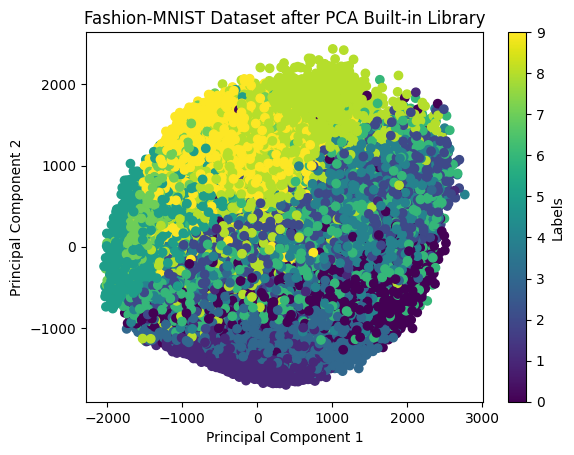

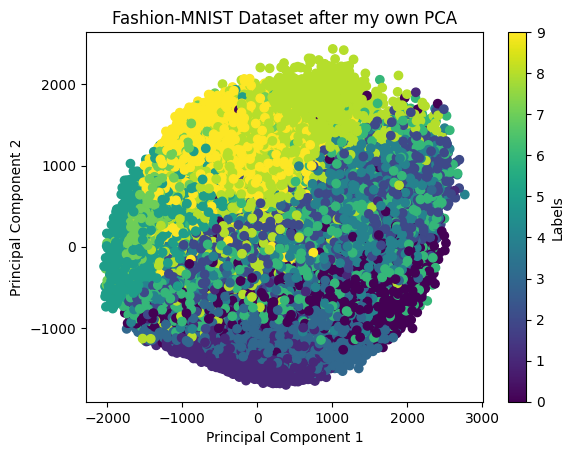

IndexError: ignored

In [2]:
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neural_network import MLPClassifier
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from threading import Thread
from google.colab import drive


class PCA_OWN:
    def __init__(self, n_components):
        self.n_components = n_components
        self.components = None
        self.mean = None

    def fit(self, X):
        # Calculate the mean of the input data
        self.mean = np.mean(X, axis=0)

        # Center the data by subtracting the mean
        centered_X = X - self.mean

        # Calculate the covariance matrix
        covariance = np.cov(centered_X, rowvar=False)

        # Calculate the eigenvalues and eigenvectors of the covariance matrix
        eigenvalues, eigenvectors = np.linalg.eig(covariance)

        # Sort the eigenvalues and eigenvectors in descending order
        indices = np.argsort(eigenvalues)[::-1]
        sorted_eigenvalues = eigenvalues[indices]
        sorted_eigenvectors = eigenvectors[:, indices]

        # Select the top n_components eigenvectors
        self.components = sorted_eigenvectors[:, :self.n_components]

    def transform(self, X):
        # Center the data by subtracting the mean
        centered_X = X - self.mean

        # Project the centered data onto the eigenvectors
        transformed_X = np.dot(centered_X, self.components)

        return transformed_X


def svm_func(X_Train, X_Test, is_own: bool):
    # Define the parameter grid with different kernel options
    param_grid = {'kernel': ['poly']}

    # Create an SVM classifier
    svm = SVC()

    # SVM Classifier with Cross-Validation with 5 folds
    grid_search = GridSearchCV(svm, param_grid, cv=5, scoring='accuracy', )

    # Fit the GridSearchCV object to the training data
    t1 = datetime.datetime.now()
    grid_search.fit(X_Train, y_train)
    t2 = datetime.datetime.now()

    # Get the best kernel and its associated accuracy
    best_kernel = grid_search.best_params_['kernel']
    best_accuracy = grid_search.best_score_
    best_estimator = grid_search.best_estimator_

    #  Get the Metrics
    y_predict = best_estimator.predict(X_Test)
    best_accuracy_test = accuracy_score(y_test, y_predict)
    best_precision_test = precision_score(y_test, y_predict, average='weighted')
    best_recall_test = recall_score(y_test, y_predict, average='weighted')
    best_f1_test = f1_score(y_test, y_predict, average='weighted')
    best_confusion_matrix_test = confusion_matrix(y_test, y_predict)

    # Get the accuracy, precision, recall, and F1 score of all kernel types
    all_kernels = grid_search.cv_results_['param_kernel']
    all_accuracies = []
    for i in range(5):  # CV Number of Folds
        all_accuracies.append(grid_search.cv_results_[f'split{i}_test_score'][0])
    all_precision = []
    for i in range(5):  # CV Number of Folds
        all_precision.append(grid_search.cv_results_[f'split{i}_test_score'][1])
    all_recall = []
    for i in range(5):  # CV Number of Folds
        all_recall.append(grid_search.cv_results_[f'split{i}_test_score'][2])
    all_f1 = []
    for i in range(5):  # CV Number of Folds
        all_f1.append((all_precision[i] * all_recall[i]) / (all_precision[i] + all_recall[i]))  # Because F1
        # Score is not Provided directly in the return result from grid search
    tuning_time = t2 - t1

    #  Result
    result = f"Train Results : \nBest Kernel : {best_kernel}\nBest Accuracy : {best_accuracy}\n Best Precision : {max(*all_precision)}" \
             f"\nBest Recall : {max(*all_recall)}\nBest F1 Score : {max(*all_f1)}\nTuning Time : {tuning_time}\n" \
             f"********************************************************************************"

    for kernel, accuracy, precision, recall, f1 in zip(all_kernels, all_accuracies, all_precision, all_recall, all_f1):
        result += f"\nKernel : {kernel}, Accuracy : {accuracy}, Precision : {precision}, Recall : {recall}, " \
                  f"F1 Score : {f1}"

    result += f"\nTest Results : \nBest Accuracy : {best_accuracy_test}\nBest Precision : {best_precision_test}" \
              f"\nBest Recall : {best_recall_test}\nBest F1 Score : {best_f1_test}" \
              f"\nBest Confusion Matrix : {best_confusion_matrix_test}"

    #  Log
    st1 = 'built-in'
    st2 = 'own'
    if is_own:
        with open(f"/content/drive/MyDrive/results_svm_{st1}.txt", "w") as f:
            f.writelines(result)
    if not is_own:
        with open(f"/content/drive/MyDrive/results_svm_{st2}.txt", "w") as f:
            f.writelines(result)
    print(result)


def bayes_func(X_Train, X_Test, is_own: bool):
    # Create an Instance of Bayes Classifier
    naive_bayes = GaussianNB()

    # Train the Model
    t1 = datetime.datetime.now()
    naive_bayes.fit(X_Train, y_train)
    t2 = datetime.datetime.now()

    # Test the Model
    y_predict = naive_bayes.predict(X_Test)

    # Prepare the Results
    accuracy = accuracy_score(y_test, y_predict)
    precision = precision_score(y_test, y_predict, average='weighted')
    recall = recall_score(y_test, y_predict, average='weighted')
    f1 = f1_score(y_test, y_predict, average='weighted')
    confusion_mat = confusion_matrix(y_test, y_predict)
    training_time = t2 - t1

    #  Result
    result = f"Accuracy : {accuracy}\nPrecision : {precision}\nRecall : {recall}\nF1 Score : {f1}" \
             f"\nConfusion Matrix : {confusion_mat}\nTraining Time : {training_time}"

    #  Log
    st1 = 'built-in'
    st2 = 'own'
    if is_own:
        with open(f"/content/drive/MyDrive/results_bayes_{st1}.txt", "w") as f:
            f.writelines(result)
    if not is_own:
        with open(f"/content/drive/MyDrive/results_bayes_{st2}.txt", "w") as f:
            f.writelines(result)
    print(result)


def knn_func(X_Train, X_Test, is_own: bool):
    # Define hyperparameters to search over
    param_dist = {
        'n_neighbors': np.arange(1, 101),  # Range of neighbors to try
    }

    # Perform randomized search for best number of neighbors using 5-fold cross-validation
    t1 = datetime.datetime.now()
    random_search = RandomizedSearchCV(KNeighborsClassifier(), param_dist, n_iter=10, cv=5)
    random_search.fit(X_Train, y_train)
    t2 = datetime.datetime.now()

    # Get best number of neighbors
    best_neighbors = random_search.best_params_['n_neighbors']

    # Use the best number of neighbors to create the KNN classifier
    knn_best = random_search.best_estimator_

    # Predict labels for test data
    y_predict = knn_best.predict(X_Test)

    # Calculate accuracy, precision, recall, and F1 score, confusion matrix and tuning time
    accuracy = accuracy_score(y_test, y_predict)
    precision = precision_score(y_test, y_predict, average='weighted')
    recall = recall_score(y_test, y_predict, average='weighted')
    f1 = f1_score(y_test, y_predict, average='weighted')
    confusion_mat = confusion_matrix(y_test, y_predict)
    tuning_time = t2 - t1

    #  Result
    result = f"Accuracy : {accuracy}\nPrecision : {precision}\nRecall : {recall}\nF1 Score : {f1}" \
             f"\nConfusion Matrix : {confusion_mat}\nBest number of neighbors : {best_neighbors}" \
             f"\nTuning Time : {tuning_time}"

    #  Log
    st1 = 'built-in'
    st2 = 'own'
    if is_own:
        with open(f"/content/drive/MyDrive/results_knn_{st1}.txt", "w") as f:
            f.writelines(result)
    if not is_own:
        with open(f"/content/drive/MyDrive/results_knn_{st2}.txt", "w") as f:
            f.writelines(result)
    print(result)


def mlp_func(X_Train, X_Test, is_own: bool):
    # Define a range of choices for each Hyper-Parameter
    param_grid = {
        'hidden_layer_sizes': [(100,), (50, 50), (100, 100), (50, 100)],
        'activation': ['relu', 'tanh', 'logistic',],
        'learning_rate_init': [0.001, 0.01],
        'batch_size': [16و 32و 64],
        'max_iter': [10و 20و 30],
    }

    # Create an MLP classifier
    mlp = MLPClassifier(random_state=42)

    # Five Fold Cross Validation with MLP Classifier
    grid_search = GridSearchCV(mlp, param_grid, cv=5)

    # Fit on the Data
    t1 = datetime.datetime.now()
    grid_search.fit(X_Train, y_train)
    t2 = datetime.datetime.now()

    # Get the best hyperparameters
    best_params = grid_search.best_params_

    #  Get the Best Estimator
    mlp_best = grid_search.best_estimator_

    # Predict labels for test data
    y_predict = mlp_best.predict(X_Test)

    # Calculate accuracy, precision, recall, and F1 score, confusion matrix and tuning time
    accuracy = accuracy_score(y_test, y_predict)
    precision = precision_score(y_test, y_predict, average='weighted')
    recall = recall_score(y_test, y_predict, average='weighted')
    f1 = f1_score(y_test, y_predict, average='weighted')
    confusion_mat = confusion_matrix(y_test, y_predict)
    tuning_time = t2 - t1

    # Result
    result = f"Best Parameters : {best_params}\nBest Accuracy : {accuracy}\nBest Precision : {precision}" \
             f"\nBest Recall : {recall}\nBest F1 Score : {f1}\nBest Confusion Matrix : {confusion_mat}" \
             f"Tuning Time : {tuning_time}"

    #  Log
    st1 = 'built-in'
    st2 = 'own'
    if is_own:
        with open(f"/content/drive/MyDrive/results_mlp_{st1}.txt", "w") as f:
            f.writelines(result)
    if not is_own:
        with open(f"/content/drive/MyDrive/results_mlp_{st2}.txt", "w") as f:
            f.writelines(result)
    print(result)


if __name__ == '__main__':
    # Load the Fashion-MNIST dataset
    drive.mount('/content/drive')
    data_train = pd.read_csv('/content/drive/MyDrive/fashion-mnist_train.csv')
    data_test = pd.read_csv('/content/drive/MyDrive/fashion-mnist_test.csv')

    # Separate labels (y) from features (X) on Train Data
    X_train = data_train.iloc[:, 1:].values
    y_train = data_train.iloc[:, 0].values

    # Separate labels (y) from features (X) on Test Data
    X_test = data_test.iloc[:, 1:].values
    y_test = data_test.iloc[:, 0].values

    # Pre_Processing / Handle Missing Value

    # On X_train
    error_count_X_train = 0
    for i in range(len(X_train)):
        for j in range(len(X_train[i])):
            if X_train[i][j] not in range(0, 256):  # RGB Range
                error_count_X_train += 1

    # On X_test
    error_count_X_test = 0
    for i in range(len(X_test)):
        for j in range(len(X_test[i])):
            if X_test[i][j] not in range(0, 256):  # RGB Range
                error_count_X_test += 1

    # On y_train
    error_count_y_train = 0
    for i in range(len(y_train)):
        if y_train[i] not in range(0, 10):  # Class Labels Range
            error_count_y_train += 1

    # On y_test
    error_count_y_test = 0
    for i in range(len(y_test)):
        if y_test[i] not in range(0, 10):  # Class Labels Range
            error_count_y_test += 1

    # Checks all the Data here
    if error_count_X_train != 0 and error_count_y_train != 0 and error_count_X_test != 0 and error_count_y_test != 0:
        raise Exception("Missing Value or Wrong Value")
    error_result = f"Error in X_Train : {error_count_X_train}\nError in y_Train : {error_count_y_train}\n" \
          f"Error in X_Test : {error_count_X_test}\nError in y_Test : {error_count_y_test}"
    with open("/content/drive/MyDrive/result_error.txt", "w") as f:
        f.writelines(error_result)
    print(error_result)

    # Perform PCA
    pca = PCA(n_components=0.95)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)

    pca_own = PCA_OWN(n_components=len(X_train_pca[0]))  # I used the feature in built-in PCA to preserve 95 percent of
    # the Variance and then use the ideal number of component in my own PCA class
    pca_own.fit(X_train)
    X_train_pca_own = pca_own.transform(X_train)
    X_test_pca_own = pca_own.transform(X_test)

    # Plot the data points in the transformed space with built-in Library
    plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, cmap='viridis')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.title('Fashion-MNIST Dataset after PCA Built-in Library')
    plt.colorbar(label='Labels')
    plt.show()

    #  Plot the data points in the transformed space with my own PCA
    plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, cmap='viridis')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.title('Fashion-MNIST Dataset after my own PCA')
    plt.colorbar(label='Labels')
    plt.show()

    # Threading and process all the models together with PCA built-in
    Thread(name = 'non-daemon', target=svm_func, args=[X_train_pca, X_test_pca, True]).start()  # Checked
    Thread(name = 'non-daemon', target=knn_func, args=[X_train_pca, X_test_pca, True]).start()  # Checked
    Thread(name = 'non-daemon', target=bayes_func, args=[X_train_pca, X_test_pca, True]).start()  # Checked
    Thread(name = 'non-daemon', target=mlp_func, args=[X_train_pca, X_test_pca, True]).start()  # Checked

    # Threading and process all the models together with my own PCA
    Thread(name = 'non-daemon', target=svm_func, args=[X_train_pca_own, X_test_pca_own, False]).start()  # Checked
    Thread(name = 'non-daemon', target=knn_func, args=[X_train_pca_own, X_test_pca_own, False]).start()  # Checked
    Thread(name = 'non-daemon', target=bayes_func, args=[X_train_pca_own, X_test_pca_own, False]).start()  # Checked
    Thread(name = 'non-daemon', target=mlp_func, args=[X_train_pca_own, X_test_pca_own, False]).start()  # Checked

    #  Process on data with PCA built-in
    # svm_func(X_train_pca, X_test_pca, True)
    # knn_func(X_train_pca, X_test_pca, True)
    # bayes_func(X_train_pca, X_test_pca, True)
    # mlp_func(X_train_pca, X_test_pca, True)

    #  Process on data with my own PCA
    # svm_func(X_train_pca_own, X_test_pca_own, False)
    # knn_func(X_train_pca_own, X_test_pca_own, False)
    # bayes_func(X_train_pca_own, X_test_pca_own, False)
    # mlp_func(X_train_pca_own, X_test_pca_own, False)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')